## Import

In [63]:
## import
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score



## Data Cleaning/ Merging 

In [2]:
## reading in datasets 
df_mask = pd.read_csv('data/mask-use-by-county.csv')
df_votes = pd.read_csv('data/president_county.csv')
df_results = pd.read_csv('data/president_county_candidate.csv')
df_county = pd.read_csv('data/data.csv', encoding = 'ISO-8859-1')

To merge these data sets, we need an index that appoints counties to the county FP (or vice versa).  
Furthermore, df_results needs to be transformed into just Biden and Trump by voting percentage (acheivable by using the total votes in df_votes).

In [3]:
## joining df_mask and df_county on fips code 
df_mask = df_mask.rename(columns= {'COUNTYFP':'fips'})

In [4]:
## cleaning df_county to only useful columns 
df_county = df_county[['fips', 'state_name', 'county_name']]

In [5]:
df_mask = df_mask.merge(df_county, left_on='fips', right_on='fips', suffixes=('_left', '_right'))

In [6]:
## retaining only useful columns 
df_mask = df_mask[['fips', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]

In [7]:
df_results = df_results.merge(df_votes, left_on=['state', 'county'], right_on=['state', 'county'], suffixes=('_left', '_right') )

In [8]:
## try to get fips on df_results 
df_results = df_results.merge(df_county, left_on=['state', 'county'], right_on=['state_name', 'county_name'])

In [9]:
## retaining only useful columns 
df_results = df_results[['fips', 'state', 'county', 'candidate', 'won', 'total_votes_left', 'total_votes_right' ]]



In [10]:
## obtaining voted percentage in the election 
df_results['percentage'] = df_results['total_votes_left'] / df_results['total_votes_right']

In [11]:
## merging results with mask wearing percentage 
df_results = df_results.merge(df_mask, left_on='fips', right_on='fips',suffixes=('_left', '_right') )

In [12]:
## obtaining df_biden and df_trump
df_biden = df_results[df_results['candidate'] == 'Joe Biden']
df_trump = df_results[df_results['candidate'] == 'Donald Trump']

## Analysis 

### Dataset Summary 

In [13]:
## figuring out how many counties voted for trump and biden 
print('{} counties voted for Biden'.format(sum(df_biden['won'] == True)))
print('{} counties voted for Trump'.format(sum(df_biden['won'] == False)))

486 counties voted for Biden
2560 counties voted for Trump


Making a conclusion from this dataset should be done with extra care. Counties that voted for biden are vastly outnumbered by the ones voted for Trump. This might potentially create an inbalance in our model's prediction.

Text(0.5, 1.0, 'Mask Wearing in Trump Counties')

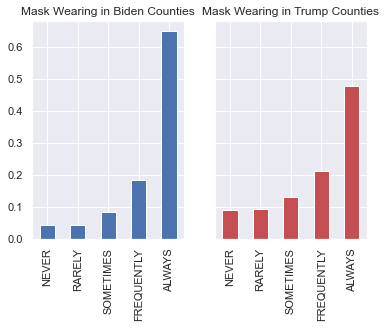

In [14]:
## plotting model summary based on trumpe and biden 
sns.set()
fig, ax = plt.subplots(1,2, sharey = True)
df_biden[df_biden['won'] == 1][['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']].mean().plot(kind = 'bar', label = 'biden', color = 'b', ax = ax[0])
df_biden[df_biden['won'] == 0][['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']].mean().plot(kind = 'bar', label = 'trump', color = 'r', ax = ax[1])
ax[0].set_title('Mask Wearing in Biden Counties')
ax[1].set_title('Mask Wearing in Trump Counties')


First, I intend to find if they is a strong correlation between likiness to wear mask and voting for a presidential candidate. I will conduct two linear regressions, one for each of Biden and Trump. The independent variable will be the percentage of people in a county that has a positive response to mask wearing, done so by adding 'Frequently' and 'Always' together.    
  
I choose to do this over using every mask wearing frequency as the independent variable because, obviously, the independent variables would add up to 1.   

The dependent variable is the voting percentage for a certain candidate

### Linear Regression for Biden

In [15]:
## getting column for positive response to wearing mask 
df_trump['positive_mask_wearing'] = df_trump['FREQUENTLY'] + df_trump['ALWAYS']
df_biden['positive_mask_wearing'] = df_biden['FREQUENTLY'] + df_biden['ALWAYS']

In [16]:
## obtain X and Y arrays from dataset 
X_biden = np.array(df_biden['positive_mask_wearing']).reshape(-1, 1)
y_biden = np.array(df_biden['percentage']).reshape(-1, 1)

In [17]:
X_train_biden, X_test_biden, y_train_biden, y_test_biden = train_test_split(
X_biden, y_biden, test_size=0.2, random_state = 1)

In [18]:
regression_biden = linear_model.LinearRegression()

In [19]:
## make regression
regression_biden.fit(X_train_biden, y_train_biden)

##prediction
biden_pred = regression_biden.predict(X_test_biden)

In [20]:
# The coefficients
print('Coefficients: \n', regression_biden.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test_biden, biden_pred))
MSE = mean_squared_error(y_test_biden, biden_pred)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test_biden, biden_pred))

Coefficients: 
 [[0.5639044]]
Mean squared error: 0.02
Coefficient of determination: 0.26


Text(0, 0.5, '% of county voting for biden')

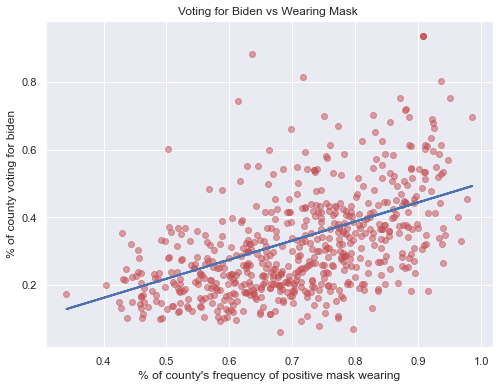

In [21]:
##plotting 
figure(figsize=(8,6))
plt.scatter(X_test_biden, y_test_biden, c = 'r', alpha = .5)
plt.plot(X_test_biden, biden_pred, c = 'b', linewidth=2)
plt.title('Voting for Biden vs Wearing Mask ')
plt.xlabel("% of county's frequency of positive mask wearing")
plt.ylabel('% of county voting for biden')

In [22]:
## summary of linear regression 
X = sm.add_constant(X_biden)
est = sm.OLS(y_biden, X)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     274.9
Date:                Sun, 03 Jan 2021   Prob (F-statistic):           3.52e-59
Time:                        13:09:42   Log-Likelihood:                -97.816
No. Observations:                3046   AIC:                             199.6
Df Residuals:                    3044   BIC:                             211.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0746      0.025     -2.973      0.0

In [23]:
## Cogs109's way of linear regression 
ones = np.ones((3046,1))
A_biden = np.hstack((ones, X_biden))

## solve for the weight vector 
w = np.linalg.lstsq(A_biden, y_biden, rcond=None)[0]

print('Linear model: percentage of voting for biden ={first} + {second} * positive mask wearing'.format(first = w[0], second = w[1]))

Linear model: percentage of voting for biden =[-0.07460831] + [0.57474506] * positive mask wearing


From both sklearn and manual least square calculation, we obtain a coefficient of around 0.56 for positive mask wearing. The y intercept is difficult to interpret intuitively, but it is unattainable because positive mask wearing is generally high enough at 0.71  

Moreover, this answers our research question. We find that the coefficient of the independent variable has a t-value of 16.5, meaning that we are statistically confident that the increase of biden's voting percentage isn't subject to chance. 



### Linear Regression for Trump 

In [24]:
## obtain X and Y arrays from dataset 
X_trump = np.array(df_trump['positive_mask_wearing']).reshape(-1, 1)
y_trump = np.array(df_trump['percentage']).reshape(-1, 1)

## splitting to training and testing datasets 
X_train_trump, X_test_trump, y_train_trump, y_test_trump = train_test_split(
X_trump, y_trump, test_size=0.2, random_state = 1)

In [25]:
regression_trump = linear_model.LinearRegression()

In [26]:
## make regression
regression_trump.fit(X_train_trump, y_train_trump)

##prediction
trump_pred = regression_trump.predict(X_test_trump)

In [27]:
# The coefficients
print('Coefficients: \n', regression_trump.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test_trump, trump_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test_trump, trump_pred))

Coefficients: 
 [[-0.75563936]]
Mean squared error: 0.02
Coefficient of determination: 0.24


Text(0, 0.5, '% of county voting for Trump')

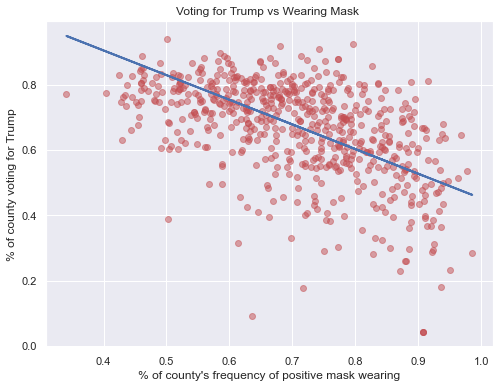

In [28]:

##plotting 
figure(figsize = (8,6))
plt.scatter(X_test_trump, y_test_trump, c = 'r', alpha = .5)
plt.plot(X_test_trump, trump_pred, c = 'b', linewidth=2)
plt.title('Voting for Trump vs Wearing Mask ')
plt.xlabel("% of county's frequency of positive mask wearing")
plt.ylabel('% of county voting for Trump')

Compared to the linear regression for biden, the linear regression for trump seems possess more correlation between mask wearing and voting percentage. The coefficient for positive mask wearing is -.755, meaning that on average, a county that sees more 0.01 increase in positive mask wearing sees a 0.00755 decrease in voting percentage for trump.  

However, the Coefficient of determination for both models seems to be the same. In other words, the voting percentage for both models are affected by positive masking wearing in the same variability. Therefore, I will only use one candidate, hereby choosing biden, going forwards. 


This seems like a fitting model. However, upon reviewing df_biden's summary, I notice a unusual stat with the mean of percetage voted for biden = 0.33. It is strange not only because biden won the election, but he won it with a popular vote of 7 million, about 53%. This is because urban cities are generally more democratic, and small rural areas are generally more republican. Urban cities are also congregated in 1 or 2 counties, thus getting vastly outnumbered by the rural areas. This might create a confounding variable within the model. 

To bypass this, I will use the outcome of the election as the output instead. The dependent variable will be whether the candidate won the election or not, described by 0 or 1. A logistic regression will be used because it is mored suitable for categorical outcomes. 

### Logisitc Regression 

In [29]:
## prepare the dataframe for logistic regression 
df_biden['won'] = df_biden['won'] * 1


In [30]:
## obtaining X and Y labels 
## using all mask wearing variables here to increase the model's predictability 
X_biden = np.array([df_biden['NEVER'], df_biden['RARELY'],df_biden['SOMETIMES'],df_biden['FREQUENTLY'],df_biden['ALWAYS']]).T
y_biden = np.array(df_biden['won']).reshape((-1,))

X_train_biden, X_test_biden, y_train_biden, y_test_biden = train_test_split(
    X_biden, y_biden, test_size=0.2, random_state = 10)


In [31]:
model = LogisticRegression()

In [32]:
## make regression
model.fit(X_train_biden, y_train_biden)

##prediction
biden_pred = model.predict(X_test_biden)

In [33]:
##reporting model 
y_pred = model.predict(X_test_biden)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test_biden, y_test_biden)))



Accuracy of logistic regression classifier on test set: 0.88


In [34]:
## confusion matrix 
cm = confusion_matrix(y_test_biden, y_pred)
cm

array([[521,   8],
       [ 67,  14]])

In [35]:
print(classification_report(y_test_biden, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       529
           1       0.64      0.17      0.27        81

    accuracy                           0.88       610
   macro avg       0.76      0.58      0.60       610
weighted avg       0.85      0.88      0.85       610



Next, we intent to examine using voting outcome in a county as the dependent variable. We acheive that with conducting a logistic regression analysis. We choose logistic regression for its advantange in predicting categorical data. 

As we can see, the accuracy of the logisitic regression is fairly high at 0.88. However, we also see that while the model is very good at predicting counties not voting for biden, it is poor at predicting counties voting for biden. From the confusion matrix, a whopping 588 predictions are nos, outnumbering the predictions for yesses of 22 predictions.   This flaw may have emerged from the disproportionate population in the counties, but we are content with our results 

The performance of these two models are incomparable. The linear regression offers insight into how much percentage voted for biden changes with more mask wearing, and the logistic regression indicates how might mask wearing change the outcome of a county's election. 

## ML Analysis with KNN 

Now, we intend to utilize machine learning techniques to predict a county's voting outcome by mask wearing tendencies. We choose to use a KNN model because....    to predict whether a county would vote for biden based on its mask wearing tendencies 

In [36]:
## obtaining X and Y labels 
## using all mask wearing variables here to increase the model's predictability 
X_biden = np.array([df_biden['NEVER'], df_biden['RARELY'],df_biden['SOMETIMES'],df_biden['FREQUENTLY'],df_biden['ALWAYS']]).T
y_biden = np.array(df_biden['won']).reshape((-1,))

X_train_biden, X_test_biden, y_train_biden, y_test_biden = train_test_split(
    X_biden, y_biden, test_size=0.2, random_state = 10)


In [37]:
print(X_train_biden.shape)
print(X_test_biden.shape)

(2436, 5)
(610, 5)


In [38]:
print(y_train_biden.shape)
print(y_test_biden.shape)

(2436,)
(610,)


In [39]:
## running k range from 1 to 30 to and measure the accuracies 
k_range = range(1,31)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_biden, y_train_biden)
    y_pred_biden = knn.predict(X_test_biden)
    scores.append(metrics.accuracy_score(y_test_biden, y_pred_biden))

Text(0.5, 0, 'K value')

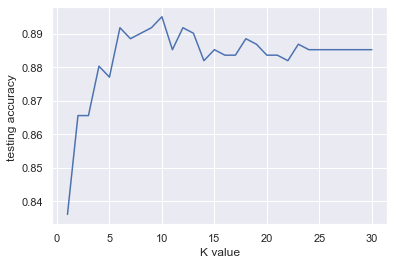

In [40]:
##plotting the test accuracies 
plt.plot(k_range, scores)
plt.ylabel('testing accuracy ')
plt.xlabel('K value')

We find that the optimal value for mask wearing is at k = 10. We set k = 1 and retrain with all the data we have to obtain the final model.

In [41]:
model = KNeighborsClassifier(n_neighbors = 10)
model.fit(X_biden, y_biden)

KNeighborsClassifier(n_neighbors=10)

In [42]:
## creating imaginary data 
county1 = [0.1, 0.0, 0, 0, 0.9]
county2 = [0.2, 0.2, 0.1, 0.1, 0.4]

data = [county1, county2]

##label 
label = {0 : 'voted for trump', 1 :'voted for biden'}

pred = model.predict(data)

print(label[pred[0]])
print(label[pred[1]])


voted for biden
voted for trump


#### Model Performance Measurement 

To measure the performance of this KNN model, we will deploy confusion matrix, f1 score, and the ROC curve

In [69]:
## obtaining the confusion matrix 
y_train_pred = cross_val_predict(model, X_train_biden, y_train_biden, cv = 3)

cm = confusion_matrix(y_train_biden, y_train_pred)

print(cm)

[[1910  121]
 [ 254  151]]


In [44]:
## getting the recall and precision rate 
print('the precision score is {:.2f} and the recall score is {:.2f}'.format(precision_score(y_train_biden, y_train_pred), recall_score(y_train_biden, y_train_pred)))

the precision score is 0.57 and the recall score is 0.34


A precision score of .57 means that out of all the predicted Biden counties, only 57% of them are actually Biden counties.   
<br>
A recall score of .34 means that out of all the Biden counties, 34% of them are predicted to be Biden counties 

As we can see, although the accuracy of this KNN=10 model is high at 90%, its precision score and recall score is extremely poor. This might be due to the fact that Trump counties vastly outnumber Biden counties. Here I inspect the f1 score (the harmonic mean of precision and recall score) corresponding to different KNN means

Sklearn provides the option to weigh precision, recall, and f1 scores if one category's training data vastly outnumbers another. In the next step, I aim to seek the best f1 score in the number of KNN means in the weighted measurements.

In [72]:
KNN = np.linspace(1,20,20).astype(int)
precision = []
recall = []
f1 = []
for knn in KNN:
    model = KNeighborsClassifier(n_neighbors = knn)
    model.fit(X_train_biden, y_train_biden)
    y_train_pred = cross_val_predict(model, X_train_biden, y_train_biden, cv = 3)
    precision.append(precision_score(y_train_biden, y_train_pred, average = 'weighted'))
    recall.append(recall_score(y_train_biden, y_train_pred, average = 'weighted'))
    f1.append(f1_score(y_train_biden, y_train_pred, average='weighted'))
     

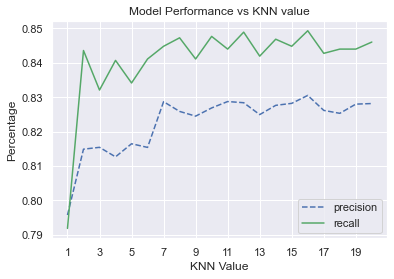

In [73]:
plt.plot(KNN, precision, 'b--', label = 'precision')
plt.plot(KNN, recall, 'g-', label='recall')
plt.xlabel('KNN Value')
plt.ylabel('Percentage')
plt.title('Model Performance vs KNN value')
plt.xticks(np.arange(1,20, 2))
plt.legend()
plt.show()

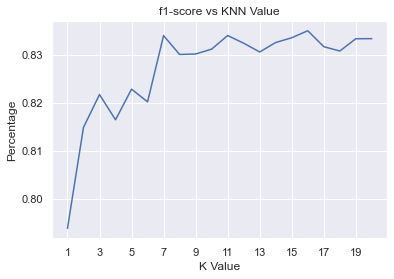

In [74]:
plt.plot(KNN, f1, '-b', label = 'f1-score')
plt.title('f1-score vs KNN Value')
plt.xlabel('K Value')
plt.ylabel('Percentage')
plt.xticks(np.arange(1,20, 2))
plt.show()

Upon further examination, both the precision and recall score are generally good in KNN means >= 7. 

However, compared to the logistic regression model, the KNN model performs much better in the f1 scores across all k-values. 

## PCA 

One of the problems of the Mask Wearing dataset, again, is that its dimensions add up to one. This is a problem because the dimensions are inversely related: when a county wears masks more in an always frequency, it has to decrease in other mask wearing frequencies. 

In [47]:
df_biden_pca = df_biden[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]

Before we begin to obtain the Principle Component of the data, it is more effective to first standardize the data. The affect of not standardizing the data before conducting PCA anaylsis is documented at
<br>

http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

In [48]:
## standardizing the data 
df_biden_std = StandardScaler().fit_transform(df_biden_pca)

In [49]:
##converting dataframe to np array
df_mask_array = np.array(df_biden_std)


In [50]:
## conduct PCA transformation 
pca = PCA(n_components = 2)
pca.fit(df_mask_array)
X = pca.transform(df_mask_array)

Here, I obtain 2 principle components. Now I attempt to plug it back into the linear regression model. But first, let's graph it on a 2D space! 

In [51]:
## make array with label 
pca_array = np.append(X, np.array(df_biden['won']).reshape((3046,1)), axis = 1)
df_pca = pd.DataFrame(pca_array)
df_pca.columns = ['PC1', 'PC2', 'label']

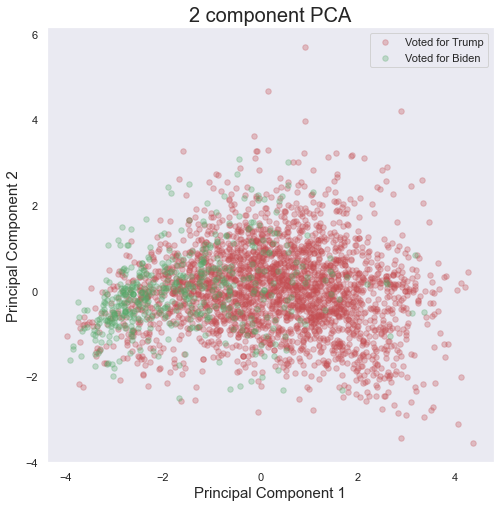

In [52]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
legend = ['Voted for Trump', 'Voted for Biden']
for target, color in zip(targets, colors):
    indices_biden = df_pca['label'] == target
    ax.scatter(df_pca.loc[indices_biden, 'PC1']
               , df_pca.loc[indices_biden, 'PC2']
               , c = color
               , s = 30
               , alpha = 0.3)
    
    
L = ax.legend(legend)
ax.grid()
plt.show()

Here we transformed the 5-dimensional mask wearing data into 2D space. Although this PCA visualization is quite noisy, as we see there are plenty of Trump counties in the Biden cluster and vice versa, we clearly see two different clusters pertained by counties that voted for Trump and counties that voted for Biden. 

<br>

More sophisticated models is required to further separate the noise in these two clusters. One way to acheive this is to add more variables that correlates with presidential voting in counties. A multiple regression is proposed in later sections. 

#### Explained Variance Ratio

In [53]:
print("The 2 principle components explains {:.2f}% of the dataset's total variance".format(100 *(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])))


The 2 principle components explains 74.84% of the dataset's total variance


As we can see, the aggregate variance explained by these 2 principle components make up around 89% of the total variance of the dataset. Here I try to increase the aggregate variance

#### PCA Dimension Optimization

In [54]:
pca = PCA()
pca.fit(df_mask_array)
cumsum = np.cumsum(pca.explained_variance_ratio_) 
d = np.argmax(cumsum >= 0.95) + 1



In [55]:
print("{} principle component dimensions captures at least 95% of the data's variabliility".format(d))


4 principle component dimensions captures at least 95% of the data's variabliility


In [56]:
##obtaining 3 principle components
pca3 = PCA(n_components = 3)
pca3.fit(df_mask_array)
X_PC3 = pca3.transform(df_mask_array)

In [57]:
pca3_array = np.append(X_PC3, np.array(df_biden['won']).reshape((3046,1)), axis = 1)
df_pca3 = pd.DataFrame(pca3_array)
df_pca3.columns = ['PC1', 'PC2', 'PC3', 'label']

In [58]:
df_pca3.head()


,PC1,PC2,PC3,label
0,-3.022730,-1.988028,0.623217,1.0
1,-3.001550,-0.537475,-0.359857,1.0
2,-3.705454,-0.858785,-0.194618,0.0
3,-2.616213,-0.077657,0.162871,1.0
4,-2.616213,-0.077657,0.162871,1.0


### Incorporating Other partisan behaviors

As we can see, the rate of mask wearing significantly correlates to the percentage of vote received by a presidential candidate. In other words, counties with higher mask wearing percentages are more likely to vote for Biden, and counties with lower mask wearking percentages are more likely to vote for Trump.   
<br>
While the finding is statistically significant, it also invokes an important question. As described in the introduction, mask wearing has become a partisan issue, and the voting affect of partisan behavior has been captured by our current model. However, there are more phenomenons that are considered to be 'partisan issues', such as the rate of working from home, rate of non-essential business opening, and rate of mobility. Moreover, as many of these behaviors are correlated to each other (i.e. a person who doesn't often wear masks are more likely to have a high mobility rate), conducting a analysis could separate a behavior's impact to presidential voting with another. <br>

Here, I intend to conduct a multiple regression anaylsis to again measure a county's rate of presidential voting and predict a county's presidential election outcome. 

#### Data Wrangling 

In [59]:
df_mobility = pd.read_csv('data/2020_US_Region_Mobility_Report.csv',low_memory=False)

In [60]:
df_mobility.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0
